# Code for effort model from cocosci 

1/26/17
* Julia Leonard
* Max K.W.

In [1]:
import pandas as pd
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/julialeonard/anaconda/lib/python2.7/site-packages/pandas/computation/expressions.py:21: UserWarning: The installed version of numexpr 2.0.1 is not supported in pandas and will be not be used
The minimum supported version is 2.1

  "version is 2.1\n".format(ver=ver), UserWarning)


### Create function for probability of reward (R) given values of effort (E), difficulty (D), and skill (S)

In [17]:
def prob_reward(e,diff,skill): #model for success
    f=(e*skill)/diff #skill and effort are not independent
    b=.06 #controls slope - was .5
    a=40 #was 30
    c=.1
    p = 1/(1+a*np.exp(-f*b))-c #softmax - scaling the function to be sigmoidal, small errors dont matter as much 
    p = max(p,0) #make sure function doesn't dip below 0
    
    return p

Let's plot a few different p(R|E,S,D)

* keept effort from 1-100

For our four conditions, here are some values that we used
* High difficulty, high skill: diff = 100, skill = 100
* High difficulty, low skill: diff = 100, skill = 50
* Low difficulty, high skill: diff = 50, skill = 100
* Low difficulty, low skill: diff = 50, skill = 50

*** for images in cocosci paper I think I had low skill at 50 but I said it was 40

0.2342823906003316

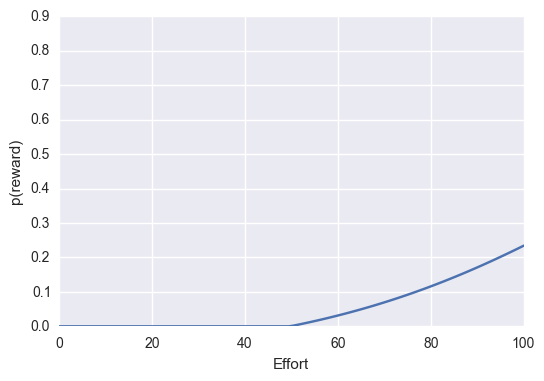

In [18]:
es=np.linspace(0,100,100)
p = [prob_reward(e,100,50) for e in es]
plt.plot(es,p)
plt.ylim([0,.9])
plt.xlabel('Effort')
plt.ylabel('p(reward)')
max(p)

#plt.savefig('/Users/julialeonard/Desktop/lowD_highS.pdf')

### Create utility function
 Utility = R x P(R|E,S,D)-cost x E

In [3]:
def get_effort(reward, cost, diff, skill):  #model for planning. Takes in diff, skill, and cost -returns effort
    Us=list()
    es = np.linspace(0, 100, 100) #used to be (0,200,100)
    for i in es:
        U=reward*prob_reward(i, diff, skill)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 
            

Let's plot a few different optimal utilities

* keept effort from 1-100
* cost = .17
* reward =30

For our four conditions, here are some values that we used
* High difficulty, high skill: diff = 100, skill = 100
* High difficulty, low skill: diff = 100, skill = 50
* Low difficulty, high skill: diff = 50, skill = 100
* Low difficulty, low skill: diff = 50, skill = 50

96.9696969697


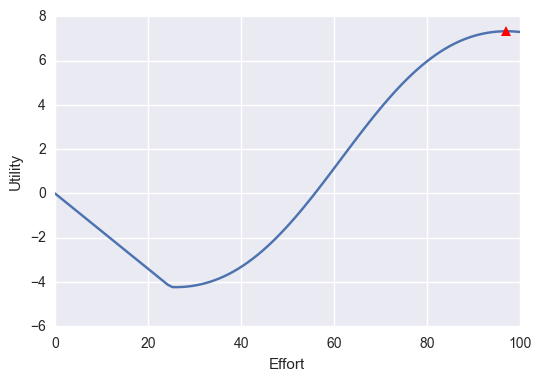

In [21]:
effort,Us,es=get_effort(30,.17,100,100) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
print effort
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/lowD_lowS.pdf')


### Build forward model with uncertainty
#### Chances of success and effort given skill, diff, reward, cost

Goal: create utility values for each value of effort given four conditions of skill and difficulty
* sample 10,000 difficulties from  beta(.3, .3)*100 distribution (best captures that toy was either hard or easy) and 10,000 skills from beta (5,3) distribution (captures that adults are more skilled than kids)
* cost = .17 (arbitrary value)
* reward =30 (arbitrary value)
* To build these posteriors, we sampled from our distributions of skill and difficulty, and if, for example, success= true (set as > .75 here) and effort = high (set at >70 here), we saved those values of difficulty and skill into posteriors for the condition ‘high effort success’ 



In [34]:
reward = 30
cost = .17
threshold = 70
#MAKE INTO DIC
sampled_skill_high = list()
sampled_diff_high = list()
sampled_skill_low = list()
sampled_diff_low = list()
sampled_skill_low_fail=list()
sampled_diff_low_fail=list()
sampled_skill_high_fail=list()
sampled_diff_high_fail=list()
diff_samp=list()
skill_samp=list()
effort_samp=list()
succes_samp=list()
for _ in xrange(10000):
    skill = np.random.beta(5,3)*100 #skill is a beta function
    #diff = np.random.uniform(1,30)
    diff = np.random.beta(.3,.3)*100 #difficulty is a beta function
    #effort,_,_=get_effort(reward, cost, diff*(min(np.random.normal(0.5,1), 1)), skill) #random noise on diff
    effort,_,_=get_effort(reward, cost, diff+(min(np.random.normal(0.5,1), 1)), skill) #julian -add noise
    #effort,_,_=get_effort(reward, cost, diff, skill)
    high_effort = effort>threshold
    low_effort=effort<threshold
    #num=np.random.random()
    num = .75
    success=prob_reward(effort,diff,skill)>num #output values where high effort and success are true
    fail=prob_reward(effort,diff,skill)<num
  
    #success = prob_reward(effort,diff,skill) > np.random.random()
    #fail = 1 - success
    ## trying to take out parameter of num
    
    diff_samp.append(diff)
    skill_samp.append(skill)
    effort_samp.append(effort)
    succes_samp.append(success)
    if success and high_effort: 
        sampled_skill_high.append(skill)
        sampled_diff_high.append(diff)
    elif success and low_effort: 
        sampled_skill_low.append(skill)
        sampled_diff_low.append(diff)
    elif fail and low_effort: 
        sampled_skill_low_fail.append(skill)
        sampled_diff_low_fail.append(diff)
    elif fail and high_effort: 
        sampled_skill_high_fail.append(skill)
        sampled_diff_high_fail.append(diff)
        

In [20]:
#export values into dataframe for R
d=np.array(diff_samp)
s=np.array(skill_samp)
e=np.array(effort_samp)
suc=np.array(succes_samp)
d=np.vstack([d, s, e, suc])
d=pd.DataFrame(data=d)
d=d.transpose()
d.columns = ['diff', 'skill','effort','success']
#d.to_csv('/Users/julialeonard/Desktop/posteriors.csv')

Let's plot some posteriors in different conditions

* sampled_skill_high
* sampled_diff_high 
* sampled_skill_low
* sampled_diff_low 
* sampled_skill_low_fail
* sampled_diff_low_fail
* sampled_skill_high_fail
* sampled_diff_high_fail

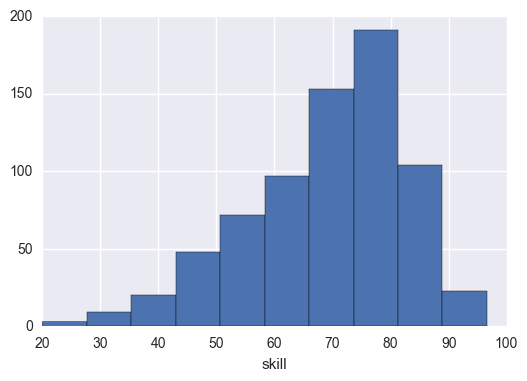

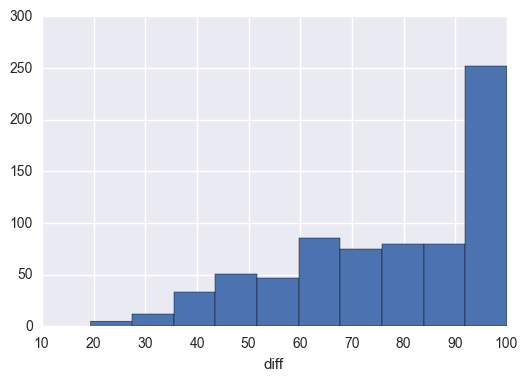

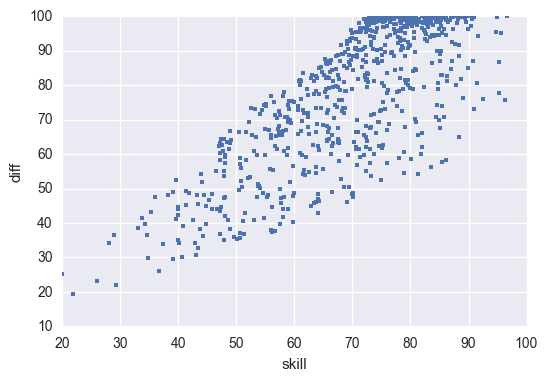

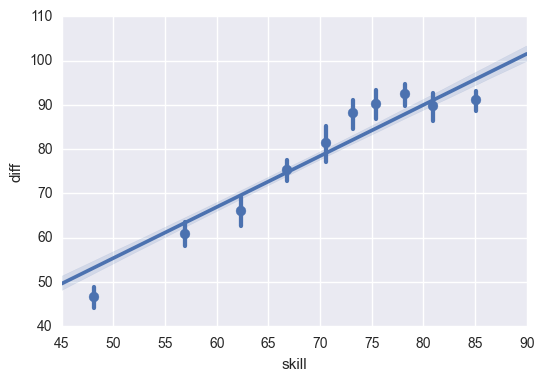

In [21]:
sampled_skill=sampled_skill_high_fail
sampled_diff=sampled_diff_high_fail
plt.hist(sampled_skill)
plt.xlabel('skill')
plt.figure()
plt.hist(sampled_diff)
plt.xlabel('diff')
plt.figure()
plt.plot(sampled_skill,sampled_diff,".")
plt.xlabel('skill')
plt.ylabel('diff')
plt.figure()
sns.regplot(np.array(sampled_skill), np.array(sampled_diff), x_bins=10)
plt.xlabel('skill')
plt.ylabel('diff')
plt.show()

(0, 100)

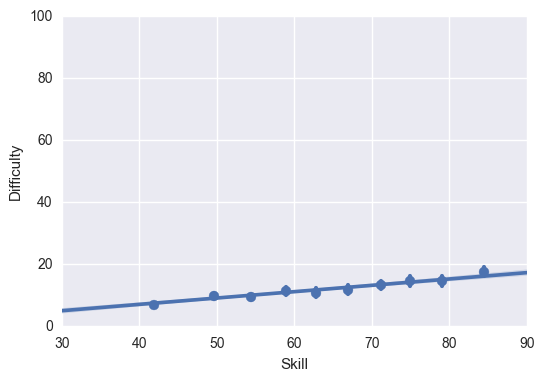

In [22]:
sampled_skill=sampled_skill_low
sampled_diff=sampled_diff_low
sns.regplot(np.array(sampled_skill), np.array(sampled_diff), x_bins=10)
plt.xlabel('Skill')
plt.ylabel('Difficulty')
plt.ylim([0,100])
#plt.show()
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/lowE_success.pdf')


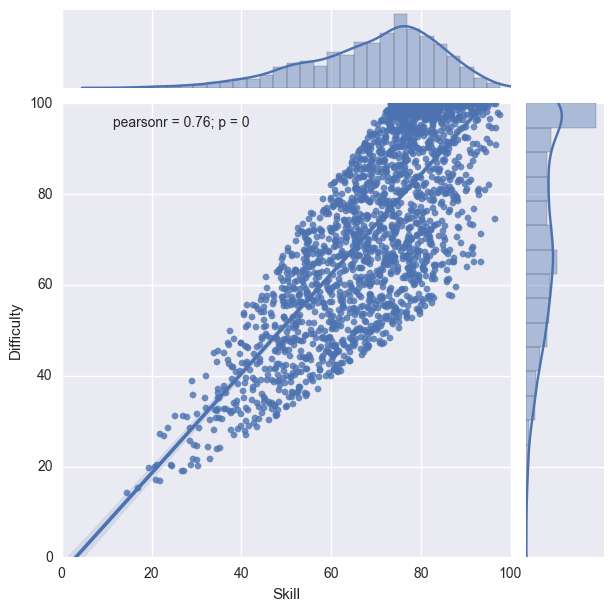

In [23]:
sampled_skill=sampled_skill_high
sampled_diff=sampled_diff_high
plt.figure(figsize=(4, 3))
sns.jointplot(np.array(sampled_skill), np.array(sampled_diff),kind="reg")
plt.ylim([0,100])
plt.xlim([0,100])
plt.xlabel('Skill')
plt.ylabel('Difficulty')
sns.set_context('paper',font_scale=2)
#plt.savefig('/Users/julialeonard/Desktop/highE_succ.pdf')

### Create function for child's effort from adult effort

* take difficulty posteriors for each condition and plug them into ‘optimal effort/ Utility’ function
* sample 10,000 times from beta(3,5)*100 distribution (kids are less skilled than adults) and randomly picked difficulties from posterioes per each condition to get output of optimal effort per skill per condition.


In [26]:
def get_your_effort(reward, cost, diff):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_effort= list()
    sampled_skill=list()
    for i in xrange(10000):
        s = np.random.beta(3,5)*100
        d = np.random.choice(diff)
        effort,_,_=get_effort(reward, cost, d+(min(np.random.normal(0,1)+.5, 1)), s) #noise on d
        #effort,_,_=get_effort(reward, cost, d, s)
        sampled_effort.append(effort)
        sampled_skill.append(s)
    
    return sampled_effort, sampled_skill

In [27]:
diff = np.random.beta(.3,.3,size=10000)*100
reward = 30
cost = .17
effort_baseline,skill_baseline = get_your_effort(reward,cost,diff)



(0, 100)

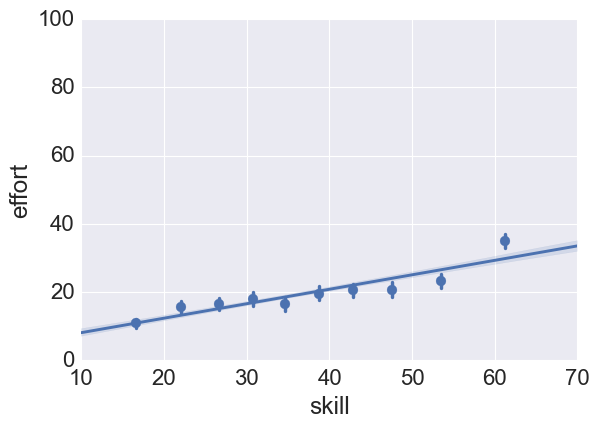

In [28]:
plt.figure()
sns.regplot(np.array(skill_baseline), np.array(effort_baseline), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])

In [29]:
reward = 30
cost = .17
diff =  sampled_diff_high
effort_high_success,skill_high_success = get_your_effort(reward,cost,diff) #used to be c=.1
diff =  sampled_diff_low
effort_low_success,skill_low_success = get_your_effort(reward,cost,diff) #used to be c=.1
diff =  sampled_diff_high_fail
effort_high_fail,skill_high_fail = get_your_effort(reward,cost,diff) #used to be c=.1
diff =  sampled_diff_low_fail
effort_low_fail,skill_low_fail = get_your_effort(reward,cost,diff) #used to be c=.1



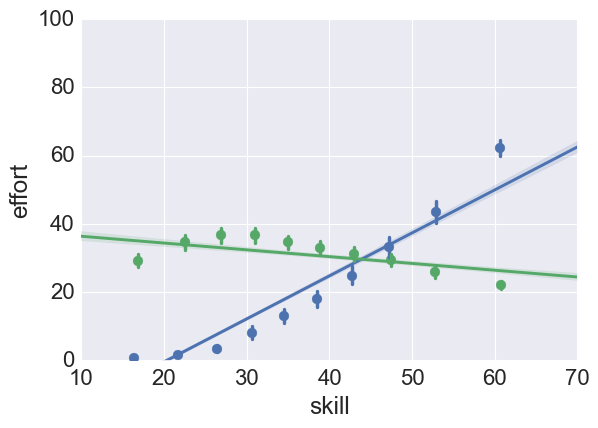

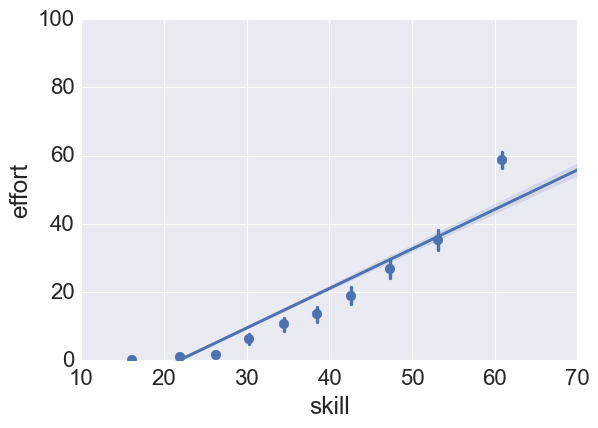

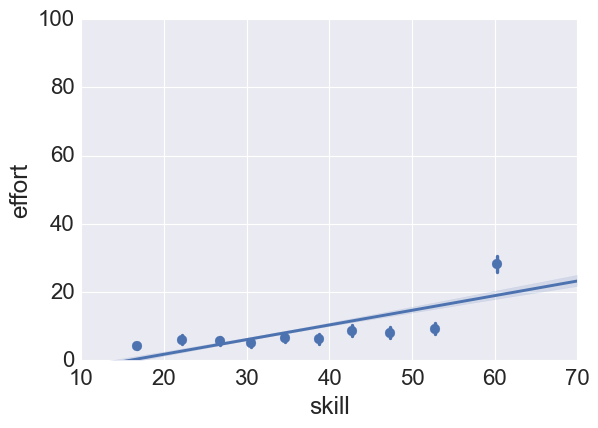

In [30]:
sns.regplot(np.array(skill_high_success), np.array(effort_high_success), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])

#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/highE_success.pdf')
#plt.figure()
sns.regplot(np.array(skill_low_success), np.array(effort_low_success), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/LowE_highE_success.pdf')
plt.figure()
sns.regplot(np.array(skill_high_fail), np.array(effort_high_fail), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/HighE_fail.pdf')
plt.figure()
sns.regplot(np.array(skill_low_fail), np.array(effort_low_fail), x_bins=10)
plt.xlabel('skill')
plt.ylabel('effort')
plt.ylim([0,100])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/LowE_fail.pdf')

plt.show()

In [31]:
#export data for external plotting
a=np.array(skill_high_success)
b=np.array(effort_high_success)
c=np.array(skill_low_success)
d=np.array(effort_low_success)
e=np.array(skill_high_fail)
f=np.array(effort_high_fail)
g=np.array(skill_low_fail)
h=np.array(effort_low_fail)
d=np.vstack([a,b,c,d,e,f,g,h])
d=pd.DataFrame(data=d)
d=d.transpose()
d.columns = ['skill_high_success', 'effort_high_success','skill_low_success','effort_low_success','skill_high_fail', 'effort_high_fail','skill_low_fail','effort_low_fail']
d.to_csv('/Users/julialeonard/Desktop/final.csv')


### Did a really hacky thing here and took final.csv into R to reformat for better plotting!

/Users/julialeonard/Dropbox/julia pc docs/MIT grad school/Classes Fall 2015/CoCoSci/final project/effort_plots.R

This script takes in final.csv and spits out reformated data on the desktop called final_eff.csv

In [32]:
Location = r'/Users/julialeonard/Desktop/final_eff.csv'
df = pd.read_csv(Location)

(10, 70)

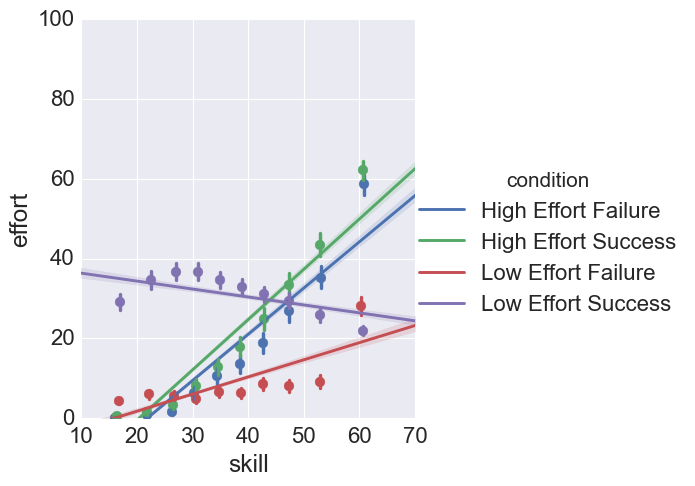

In [33]:
sns.lmplot(x="skill", y="effort", hue="condition", data=df, x_bins=10)
plt.ylim([0,100])
plt.xlim([10,70])
#plt.savefig('/Users/julialeonard/Desktop/Fall 2015/CoCoSci/final project/imgs/your_eff.pdf')


### Fit model to child data

If we make the assumption that children perceive themselves as around less than half as skilled as a very skilled adult (~100 for adult, ~47 for child), then we can compare the model mean predictions (multiplied by 3 to fit the scale of the child data) to the mean effort time in the child data 

In [43]:
def your_eff_know_skill(reward, cost, diff,skill):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_effort= list()
    sampled_skill=list()
    for i in xrange(10000):
        d = np.random.choice(diff)
        #effort,_,_=get_effort(reward, cost, d, skill)
        effort,_,_=get_effort(reward, cost, d+(min(np.random.normal(0,1)+.5, 1)), skill)
        sampled_effort.append(effort)
        sampled_skill.append(skill)
    
    return sampled_effort

In [44]:
skill=47
your_eff_know_skill(reward, cost, diff,skill)
diff =  sampled_diff_high
effort_high_success = your_eff_know_skill(reward, cost, diff,skill) #used to be c=.1
diff =  sampled_diff_low
effort_low_success = your_eff_know_skill(reward, cost, diff,skill) #used to be c=.1
diff =  sampled_diff_high_fail
effort_high_fail = your_eff_know_skill(reward, cost, diff,skill) #used to be c=.1
diff =  sampled_diff_low_fail
effort_low_fail = your_eff_know_skill(reward, cost, diff,skill) #used to be c=.1


print np.mean(effort_high_success)
print np.mean(effort_low_success)
print np.mean(effort_high_fail)
print np.mean(effort_low_fail)


48.4391919192
30.4919191919
9.59494949495
3.89747474747


In [45]:
print np.mean(effort_high_success)*2
print np.mean(effort_low_success)*2
print np.mean(effort_high_fail)*2
print np.mean(effort_low_fail)*2

high_effort_fail=30
high_effort_success=107
low_effort_fail=35
low_effort_success=57

d = {'Model' : pd.Series([103, 59, 12, 4], index=['High Effort Success', 'Low Effort Success', 'High Effort Failure', 'Low Effort Failure']),
     'Human' : pd.Series([107, 57, 30, 35], index=['High Effort Success', 'Low Effort Success', 'High Effort Failure', 'Low Effort Failure'])}

df = pd.DataFrame(d)
df
#ax = sns.barplot(x="", y="total_bill", hue="sex", data=tips)

96.8783838384
60.9838383838
19.1898989899
7.79494949495


,Human,Model
High Effort Success,107,103
Low Effort Success,57,59
High Effort Failure,30,12
Low Effort Failure,35,4
